
<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>

# <font color="#76b900">**Notebook 5:** Multimodal Architectures and Fusion Techniques</font>

In this notebook, we will explore multimodal models, focusing on how to fuse information from different data types including text, images, and audio. We will build on the architectural principles discussed in earlier notebooks and dive into advanced topics, including bi-encoders, early-fusion decoders, cross-attention mechanisms, and diffusion models.

### **Learning Objectives:**
- Understand **how to encode different modalities** into compact representations that capture both local and global information.
- Learn about **joint optimization** in late-fusion models like CLIP, which handle text and images independently and project them into a shared embedding space.
- Recognize the need for **conditioned domain-specific decoders** for generating complex outputs like audio and image-guided responses.
- Explore the **text-guided diffusion model formulation** involving a non-autoregressive decoder that can generate complex outputs while still allowing for multimodal conditioning.

By the end of this notebook, you will have a deep understanding of these multimodal fusion techniques and their relevance to modern GenAI applications.

<hr>
<br>

## **Part 5.1:** Defining A Modality?

Before diving into multimodal architectures, let's first clarify what we mean by a modality. 

A **modality** is a particular form or type of data characterized by its structure and the way it conveys information. Common modalities include:
- **Text:** Sequences of words or tokens.
- **Images:** Two-dimensional arrays of pixel values.
- **Audio:** Time-series data representing sound waves.
- **Video:** Sequences of images over time.
- **Sensor Data:** Measurements from devices like accelerometers or temperature sensors.

In your previous studies, you encountered convolution as a sparse reasoning mechanism that excels at incorporating spatial locality into model predictions. This method, which shines in handling image data, allows us to transform pixels into meaningful features through feature extraction, which can then be used to condition a dense net to serve as a classifier. 

Similarly, every data type (or modality) has inherent relationships that govern how its pieces of information interact, and different architectures are needed to handle them effectively. For instance, we’ve been focusing on transformers, with their token-wise dense layers and efficient attention mechanisms, as excellent reasoners for language. This is because language is fundamentally an ordered sequence, and attention is particularly well-suited for reasoning over sequences. But it’s important to remember that the transformer’s attention mechanism is not limited to just processing words and sentences — it’s versatile enough to be applied to a wide range of modalities and can be combined with other structure-reasoning modules as necessary.

> <div><img src="imgs/multimodal.png" width="800"/></div>
> 
> **Source: [NVIDIA Keynote at SIGGRAPH 2023 | NVIDIA](https://www.nvidia.com/en-us/events/siggraph/)**

**In this notebook, we will be primarily dealing with the following modalities:**
- **Natural Language:** Structured as an ordered sequence of tokens, each carrying semantic meaning within a context.
- **Images:** Comprised of pixel values that can capture both micro (fine-detail) and macro (big-picture) aspects in two dimensions.
- **Audio:** Structured as a time-series dataset where each point corresponds to a particular sensor reading or soundwave intensity.

Though each modality comes with its unique challenges and architectures, they share a common goal when used in multimodal systems: ***to communicate information and help convert it into usable representations (whether explicit or implicit).*** Throughout this notebook, we’ll develop a high-level intuition for how different modalities can interact, and you’ll have the opportunity to experiment with these systems yourself.

<hr>
<br>

## **Part 5.2:** Encoding Different Modalities

In earlier sections, we spent considerable time discussing how transformers encode and process text sequences. As you’ve seen, transformers excel at capturing relationships between tokens in a sequence, making them highly effective for a variety of tasks such as text classification, generation, and translation. This success with text naturally leads us to explore whether transformers can handle other data types, or modalities, that have their own structures and patterns.

We will now walk through how transformers encode and process different modalities like audio and images, each of which presents unique challenges while still benefiting from the same foundational transformer architecture.

#### **Embedding Text**

By this point, you should be quite comfortable with using transformers for text embedding. Below is some recycled code from previous notebooks to encode several strings of text which will be used later as experimental samples:

In [1]:
from transformers import BertTokenizer, BertModel
import torch

text_captions = ("Cat with paint", "rock statue", "frogs on leaf", "jellyfish")
text_dialogue = ("Cats don't usually", 'like water', 'but this one likes paint', 'quite a lot')

# Load model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
inputs = tokenizer(text_captions + text_dialogue, padding=True, return_tensors=model.framework)
num_values = inputs.get("attention_mask").sum(axis=1)

# Get text embeddings
with torch.no_grad():
    outputs = model(**inputs)
text_embeddings = outputs.last_hidden_state  # (batch_size, sequence_length, hidden_size)
print(f"{text_embeddings.shape = }")

captions_embeddings = text_embeddings[:4]
dialogue_embeddings = text_embeddings[4:]

text_embeddings.shape = torch.Size([8, 7, 768])


We now have eight sequences of embeddings, each corresponding to a text string in our inputs. Each token in the sequence has a 768-dimensional embedding capturing some hopefully-useful contextual and semantic information.

#### **Embedding Audio**

Audio is actually sequential in nature, quite like text, but differs as it explicitly models time-series data where each unit of audio takes up a set time interval. Audio-centric transformers typically operate on Mel-spectrograms (a time-frequency representation of sound) that can be treated similarly to image data with each frame representing a chunk of time along one axis (usually x) and the sampling of frequencies along the other (usually y).

> <div><img src="imgs/wav2vec2.png" width="600"/></div>
>
> **Source: [wav2vec 2.0: A Framework for Self-Supervised Learning of Speech Representations  (2202)](https://arxiv.org/abs/2006.11477)**

Using the same huggingface processing logic, we can pull in an audio-centric model like [**FAIR's wav2vec2 model**](https://huggingface.co/docs/transformers/en/model_doc/wav2vec2) to process in an audio sample which reads out our earlier text sample:

In [2]:
# import IPython
# IPython.display.Audio("audio-files/paint-cat.wav")

In [3]:
from transformers import Wav2Vec2Tokenizer, Wav2Vec2Model, AutoProcessor
import torchaudio
import numpy as np

# Load pre-trained tokenizer and model for Wav2Vec2 (a speech transformer)
processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

# Load and preprocess audio (assuming the audio file is in .wav format)
waveform, sample_rate = torchaudio.load("audio-files/paint-cat.wav")  ## NOTE: Audio file is 4.005s ~ 4s
resampler = torchaudio.transforms.Resample(sample_rate, 16000, dtype=waveform.dtype)
waveform = resampler(waveform)[0]

inputs = processor(waveform, return_tensors=model.framework, sampling_rate=16000)

# Forward pass through the model to get audio features
with torch.no_grad():
    outputs = model(**inputs)
audio_hidden_states = outputs.last_hidden_state
print(audio_hidden_states.shape)  # Shape: (batch_size, sequence_length, hidden_size)

torch.Size([1, 200, 768])


The output is an encoded representation of the audio, which can be used for downstream tasks. Each 768-dimensional vector represents the encoding of a small slice (~0.02s) of the audio file, encoded via an encoder-style transformer.

#### **Images?**
Now let’s turn to images, which are fundamentally different from text and audio. Images are 2D arrays of pixel values, so we need a way to convert these into a sequence that a transformer can process. This is where the [**Vision Transformer (ViT) formulation**](https://huggingface.co/docs/transformers/en/model_doc/vit) comes into play.

The ViT model treats an image as a sequence of patches. Each patch is mapped into some reasonable learned vector representation (and is usually flattened at some point in current formulations), and these vectors are treated like tokens in a text sequence. The transformer then learns to capture relationships between different patches, allowing it to understand both local patterns (within patches) and global context (across the whole image).

> <div><img src="imgs/vit-model.png" width="800"/></div>
>
> **Source: [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (2020)](https://arxiv.org/abs/2010.11929)**

Let’s see how we might encode an image using a ViT-enabled encoder model like [**google/vit-base-patch16-224**](https://huggingface.co/google/vit-base-patch16-224):

In [4]:
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import requests

# Load the pre-trained feature extractor and model
feature_extractor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTModel.from_pretrained('google/vit-base-patch16-224')

# Load an example image
img_files = ["paint-cat", "rock-head", "tree-frog", "two-jelly"]
images = [Image.open(f"img-files/{name}.jpg") for name in img_files]    

# Preprocess the image to fit model input
inputs = feature_extractor(images=images, return_tensors=model.framework)

# Forward pass through the model to get image features
with torch.no_grad():
    outputs = model(**inputs)
image_hidden_states = outputs.last_hidden_state
print(image_hidden_states.shape)  # Shape: (batch_size, num_patches, hidden_size)

torch.Size([4, 197, 768])


In this case, the ViT component divides the image into patches, processes them through the transformer, and outputs a sequence of encoded patches. Each patch now contains contextual information about its neighboring patches, allowing the model to understand the image in a structured way.

<hr>
<br>

## **Part 5.3:** Joint Projections

We now know that using transformers to obtain semantically dense embeddings of text, audio, and images is sensible. Regardless of the underlying structure of the data, we were able to extract *some* kind of representation with a 768-dimensional embedding dimension. Even so, we have some discrepancies to resolve:

- The language embedding is still a series of per-token embeddings.
- The audio embedding is a per-time-window embedding.
- The image embedding is a per-patch embedding.

Since we have an attention interface in each of these embedders, we know that each token has global context for the sequence. In theory, we *should* favor using the `[CLS]` token if one is provided due to its persistence in the training data, but for this example we will ignore it and just average the embedding vectors. If you're curious why, (A) these weren't jointly optimized and will give more erratic similarity results then correlated value averages, (B) these audio embeddings don't incorporate a `[CLS]` token during training.

Let's extract average embeddings for each modality to obtain a single vector representation per input:

In [5]:
## Eliminate contribution from pad tokens, since these values were obtained via batching
captions_avg_embeds = torch.sum(captions_embeddings[:,1:,:], axis=1).detach() / (num_values[:4].view(-1, 1) - 1)
dialogue_avg_embeds = torch.sum(dialogue_embeddings[:,1:,:], axis=1).detach() / (num_values[4:].view(-1, 1) - 1)

## Remove CLS token from ViT, since we said we just wanted embedding average
image_avg_embeds = torch.mean(image_hidden_states.view(4, -1, 768)[:,1:,:], axis=1).detach()

## Wav2Vec2 does not have CLS token, but we still want to divide our 4s clip into four 1s clips.
audio_avg_embeds = torch.mean(audio_hidden_states.view(4, -1, 768), axis=1).detach()

print(f"{captions_avg_embeds.shape = }")
print(f"{dialogue_avg_embeds.shape = }")
print(f"{image_avg_embeds.shape = }")
print(f"{audio_avg_embeds.shape = }")

captions_avg_embeds.shape = torch.Size([4, 768])
dialogue_avg_embeds.shape = torch.Size([4, 768])
image_avg_embeds.shape = torch.Size([4, 768])
audio_avg_embeds.shape = torch.Size([4, 768])


**We now have a single 768-dimensional embedding for each input across all modalities.** However, these embeddings are derived from models that were trained independently and are not aligned in any shared space. To illustrate this, let's compare the similarity between embeddings from different modalities:

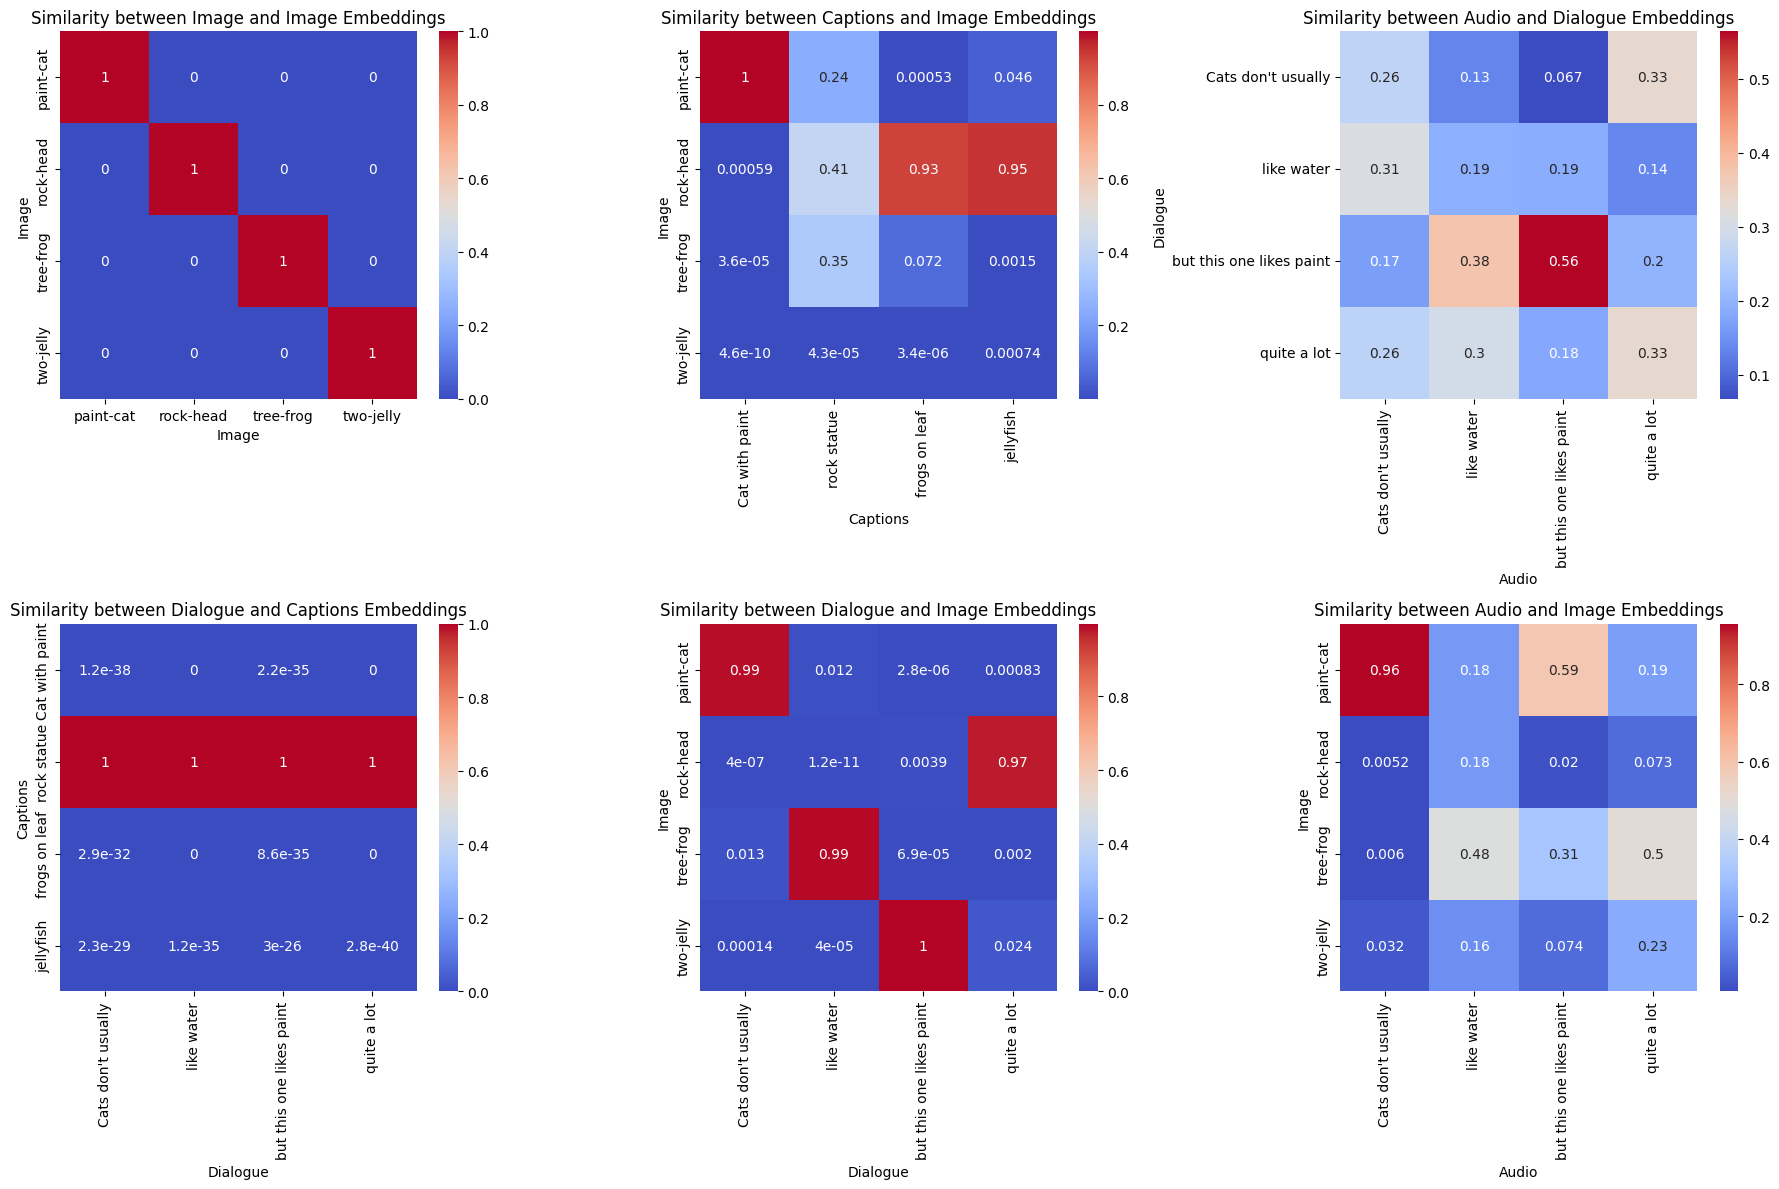

In [6]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

def plot_similarity(similarity, xlab, ylab, xticks, yticks, ax):
    # Visualization of the similarity matrix on the provided axis
    sns.heatmap(similarity.numpy(), annot=True, cmap='coolwarm', xticklabels=xticks, yticklabels=yticks, ax=ax)
    ax.set_title(f"Similarity between {xlab} and {ylab} Embeddings")
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

fig, axs = plt.subplots(2, 3, figsize=(18, 12))

## Expected Heatmap For Top Row: Diagonal Matrix. Plot [0][0] is a demo of this
sim_mtx = (image_avg_embeds @ image_avg_embeds.T).softmax(dim=0)
plot_similarity(sim_mtx, "Image", "Image", img_files, img_files, axs[0][0])

sim_mtx = (captions_avg_embeds @ image_avg_embeds.T).softmax(dim=0)
plot_similarity(sim_mtx, "Captions", "Image", text_captions, img_files, axs[0][1])

sim_mtx = (audio_avg_embeds @ dialogue_avg_embeds.T).softmax(dim=0)
plot_similarity(sim_mtx, "Audio", "Dialogue", text_dialogue, text_dialogue, axs[0][2])

## Expected Heatmap For Bottom Row: Undefined, but [1][2] doesn't look terrible...
sim_mtx = (dialogue_avg_embeds @ captions_avg_embeds.T).softmax(dim=0)
plot_similarity(sim_mtx, "Dialogue", "Captions", text_dialogue, text_captions, axs[1][0])

sim_mtx = (dialogue_avg_embeds @ image_avg_embeds.T).softmax(dim=0)
plot_similarity(sim_mtx, "Dialogue", "Image", text_dialogue, img_files, axs[1][1])

sim_mtx = (audio_avg_embeds @ image_avg_embeds.T).softmax(dim=0)
plot_similarity(sim_mtx, "Audio", "Image", text_dialogue, img_files, axs[1][2])

plt.tight_layout()
plt.show()

If you look hard, you'll notice that there are still some sensical relationships on display. The strong alignment of some input embeddings with some output embeddings could be indicative of actual synergy (i.e. possibly bottom-right), but could also be completely nonsensical (possibly bottom-left). This is because **these representations are independently optimized for downstream learning**, thereby forming completely different implicit representations.

### **Joint Optimization with CLIP**

To address this limitation, models like [**CLIP (Contrastive Language–Image Pre-training)**](https://openai.com/index/clip/) are trained specifically to project different modalities — like images and text — into a shared embedding space in which they can be easily compared. This shared space is optimized jointly across both modalities so that the model learns representations that are mutually consistent, i.e. similar images and text are mapped closer together while unrelated pairs are pushed apart.

CLIP does this through a **contrastive learning objective**, which aligns the embeddings of paired images and their captions by minimizing the distance between them in the shared space while maximizing the distance between unrelated pairs. This joint optimization process encourages the model to learn useful modular representations that can facilitate that multimodal tasks like image-text retrieval.

> <div><img src="imgs/clip-arch.png" width="1000"/></div>
>
> **Source: [Learning Transferable Visual Models From Natural Language Supervision  (2021)](https://arxiv.org/abs/2103.00020)**

To demonstrate the power of joint optimization, let’s explore how CLIP embeddings perform on a task it’s actually designed for — aligning images with their corresponding text descriptions. This task is one of CLIP's core strengths, and we'll see how well it handles the alignment of images and captions in its shared embedding space.

TypeError: 'NoneType' object is not subscriptable

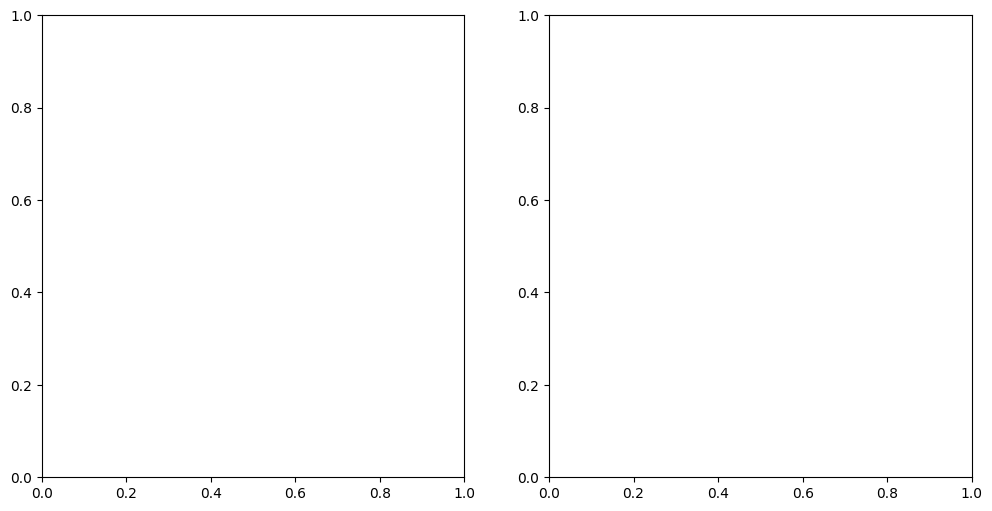

In [7]:
from transformers import CLIPProcessor, CLIPModel

text_captions = ("Cat with paint", "rock statue", "frogs on leaf", "jellyfish")
text_dialogue = ("Cats don't usually", 'like water', 'but this one likes paint', 'quite a lot')

#######################################################################
## TODO: Load in a clip model of choice, reading over the model-card recommendations.
## HINT: We'd recommend openai/clip-vit-base-patch32
model = None
processor = None

#######################################################################
## TODO: Compute the text and image embeddings for analysis
inputs_text = None
inputs_images = None

#######################################################################
## TODO: Get the text and image embeddings for final visual
with torch.no_grad():
    text_embeddings = None
    image_embeddings = None

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sim_mtx = (text_embeddings[:4] @ image_embeddings.T).softmax(dim=0)
plot_similarity(sim_mtx, "Captions", "Image", text_captions, img_files, axs[0])

sim_mtx = (text_embeddings[4:] @ image_embeddings.T).softmax(dim=0)
plot_similarity(sim_mtx, "Dialogue", "Image", text_dialogue, img_files, axs[1])

plt.tight_layout()
plt.show()

This demonstrates that joint optimization during training can enforce relationships between modalities, leading to useful emergent behaviors. With CLIP, the embeddings are aligned across modalities, and the similarity matrices show meaningful relationships for its advertised task (aligning images with their captions). Note that this does not necessarily make them intuitively aligned for *arbitrary tasks*, as showcased with the dialog-image similarity results which may be a bit counterintuitive.

<details>
<summary><b>Exercise Solution</b></summary>

```python
#######################################################################
## TODO: Load in a clip model of choice, reading over the model-card recommendations.
## HINT: We'd recommend openai/clip-vit-base-patch32
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

#######################################################################
## TODO: Compute the text and image embeddings for analysis
inputs_text = processor(text=text_captions + text_dialogue, return_tensors="pt", padding=True)
inputs_images = processor(images=images, return_tensors="pt", padding=True)

#######################################################################
## TODO: Get the text and image embeddings for final visual
with torch.no_grad():
    text_embeddings = model.get_text_features(**inputs_text)
    image_embeddings = model.get_image_features(**inputs_images)

```
</details>

<hr>
<br>

## **Part 5.4:** Combining Multimodal Encoders with Decoders

Up to this point, we've seen that encoding different modalities into compact representations allows us to compare and contrast them for downstream tasks. Strategies like the one CLIP uses allow us to compute these embeddings independently per modality, making them useful for tasks such as aligning images with captions or retrieving relevant information based on similarity. This is known as a **bi-encoder formulation**, and takes advantage of **late fusion** where the information from both modalities is fused relatively late in the inference process. 

However, simply comparing embeddings at the end is not sufficient for more complex tasks and deeper reasoning. To remedy this, some models choose to adopt **early fusion** approaches like **cross-encoding** where both distributions are fed in through the same input pathway from the start. This is similar to the BERT next-sentence prediction task, but for the case when the two sequences are actually from different domains and the model includes a utility to project the data into a shared or jointly-reasonable input space. 

### **Cross-Attention: Bridging Modalities in Generation Tasks**

While early fusion is definitely important for more complex tasks, encoding is once again not sufficient for generating complex structured data outputs. For example, tasks like generating textual descriptions from images (image captioning) or transcribing audio into text (speech recognition) should not be doable with encoder-only approaches. Just like last time, what we really need is a domain-specific decoder that can interpret the encoded information and generate meaningful outputs with reasonable prior assumptions regarding domain structure. In the same way that we used the decoder-style transformer architecture to generate non-trivial sequences based on text conditioning, we can condition on non-textual embeddings and/or generate non-textual sequences. 

#### **Image Captioning with ViT + GPT2**

In image captioning, we aim to generate a descriptive sentence that corresponds to a given image. This requires: 
- A visual encoder (such as ViT) to extract features from the image 
- A language decoder (such as GPT-2) to generate the text. 

The cross-attention mechanism plays a crucial role by allowing the decoder to specialize in word creation while letting the encoder focus on its visual input. We can showcase this with the relatively lightweight [**vit-gpt2-image-captioning model**](https://huggingface.co/nlpconnect/vit-gpt2-image-captioning) described in more detail [**in the author's blog post**](https://ankur3107.github.io/blogs/the-illustrated-image-captioning-using-transformers/).

Let's see a usage example using both a Huggingface pipeline and a slightly-more-manual inference pass to validate that our underlying input pathway intuition makes sense:

In [ ]:
import IPython
from transformers import pipeline
from PIL import Image

#################################################################################################
## Easy Pipeline

img_files = ["paint-cat", "rock-head", "tree-frog", "two-jelly"]
images = [Image.open(f"img-files/{name}.jpg") for name in img_files]    

vit_pipe = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")
for name, image in zip(img_files, images):
    print(f"{name}: {vit_pipe(image)}")
print()

#################################################################################################
## Manually

## Generate the inputs for both the image encoder AND the text decoder
## - We want to generate text, so the decoder should deal with it to avoid structure loss
## - We want to image to HELP the generation but do not want image structure to propagate to output
starter_phrase = "I love"
starter_tokens = vit_pipe.tokenizer([starter_phrase] * len(images), return_tensors=vit_pipe.framework)
image_embeddings = vit_pipe.image_processor(images, return_tensors=vit_pipe.framework)
print("Start Inputs:", {k:getattr(v, "shape", v) for k,v in starter_tokens.items()})
print("Image Inputs:", {k:getattr(v, "shape", v) for k,v in image_embeddings.items()})

# Generate transcription by passing all of this into the model. You'll get a vector of token IDs
generated_ids = vit_pipe.model.generate(**starter_tokens, **image_embeddings)
print("\nModel Outputs:", generated_ids.shape)

## Detokenize back to actual human language and print!
transcription = vit_pipe.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
print("\nTranscript:", transcription)

<br>

#### **Speech Recognition with Whisper**
In speech recognition, the goal is to generate a text transcription from an audio input. Much like image captioning, this requires an encoder to process the audio and a decoder to generate the text. In this case, models like [**OpenAI's Whisper options**](https://openai.com/index/whisper/) learn to map raw audio signals to text by using cross-attention to attend to different parts of the audio input while generating each word in the transcription.

> <div><img src="imgs/whisper-arch.png" width="700"/></div>
>
> **Source: [Introducing Whisper | OpenAI](https://openai.com/research/whisper)**

Let’s look at how Whisper can be used for speech transcription, and note how the code differs from the ViT example (and why it makes sense given the earlier Wav2Vec2 audio encoder):

In [ ]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import torchaudio

from glob import glob

dev = "cuda" if torch.cuda.is_available() else "cpu"

## whisper-large-v2 recommended, but slow. For only english, whisper-base is fine
## Upgrading to a larger model will lead to better hard-case results and formatting
processor = WhisperProcessor.from_pretrained("openai/whisper-large-v3", device=dev)
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-large-v3").to(dev)

# Load and process audio file
def transcribe_file(audio_file):
    audio, _ = torchaudio.load(audio_file)
    audio = audio.squeeze().numpy()
    inputs = processor(audio, return_tensors=model.framework, sampling_rate=16000, device=dev)
    generated_ids = model.generate(inputs["input_features"].to(dev), max_length=50)
    transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)
    return transcription[0]

for filename in sorted(glob("audio-files/*")):
    print(f"{filename}: {transcribe_file(filename)}")

<br>

#### **[Aside] Decoder-Only Multimodal Models**

We've previously discussed the pros and cons of cross-attention, and once again can derive why lightweight purpose-driven models like those above are natural candidates. However, a decoder-only extension is also very popular and makes its appearance in **vision-language models** (VLMs). These will be experimented with in the next notebook, but the high-level intuition is pretty simple: 

- **Linear projection** maps the image features into a space that aligns with the text embeddings of the LLM. Again, this is technically a multimodal encoding exercise regarding the visual input, but it's decoder-only from the language perspective.
- **Decoder** (often a transformer-based LLM) processes both the projected image and the text together, effectively performing multimodal reasoning through the language model's decoding process.

This allows for a very natural extension into in-context image reasoning and even dense captioning (multi-image/video reasoning), but requires the model to learn how to deal with both tokens and some dense image projections, thereby making for a harder training formulation. For more details on such models, stay tuned for a VLM-based exercise in the next notebook and consider engaging with the likes of [**LLaVA (2023)**](https://llava-vl.github.io), [**Llama 3.2 (2024)**](https://ai.meta.com/blog/llama-3-2-connect-2024-vision-edge-mobile-devices/), [**NVLM (2024)**](https://arxiv.org/abs/2409.11402), and other state-of-the-art vision-language models. 

<hr>
<br>

## **Part 5.5:** Intro to Diffusion Decoders


For output domains where the transformer or autoregressive formulation itself is insufficient to generate good-quality results (i.e., representations that aren't natural sequences), we may need specialized decoders that are better-suited for the structure of your output modality. One especially-notable approach is to transition to progressive denoising refinement, where the goal is to transition information towards the final output progressively as opposed to accumulating the output one finalized building block at a time. To illustrate this, we can bring in the example of a policy network!

#### **Policy Networks**

**Policy networks**, often used in reinforcement learning, are trained to generate actions that transition a system from one state to another. Specifically, this means that they learn roughly a `predict_action(past_actions, past_observations)` function which creates a good `new_action` to generate `new_observation = act_in_environment(new_action)`. 

Before starting this course, you probably already had the intuition that `predict_action` could be a simple action- or state-transitioning system that predicts one of the following:
$$P(A_t \ | \ O_{t-1}) \text{ such that } O_t = E(A_{\le t}) \text{ is desirable}$$
$$P(\Delta A_t \ | \ A_{t-1}, O_{t-1}) \text{ where } A_t = A_{t-1} + \Delta A_t \text{ such that } O_t \text{ is desirable}$$

In other words, you could definitely learn a transition function to predict a new action or configuration $A'$ or a configuration delta $\Delta A'$ to move from one state to another, all conditioned on: 
- **Past States**, or the true degrees of freedom which you can directly impact
- **Computed Observations**, or the rewards, image embeddings, textual instructions, etc. which come from the environment and define your optimization objective. 

And to be honest, this is still very useful for things like lightweight dynamic layers where the point is to move something from one point to another while performing vaguely-defined tasks (i.e. "move forward") and enforcing corrective measures. 

At this stage of the course, you may now see that the transformer architecture can also be used. Maybe something like the following formulation might work:

$$P(A_t \ | \ O_{<t}, A_{<t}) \text{ such that } O_t \text{ is desirable}$$
$$\text{AKA Predict each next action autoregressively from previous actions and observations}$$

This would lead you to the likes of [**Decision Transformers (2021)**](https://proceedings.neurips.cc/paper_files/paper/2021/file/7f489f642a0ddb10272b5c31057f0663-Paper.pdf) and [**VIMA (2023)**](https://vimalabs.github.io/) into a formulation that works well for generalizable sequence-conditioned action models. And you get there with the simple intuition that an architecture adept at sequence reasoning can be used to exploit the sequential structure of data to generate insights and new data.

#### **Sequence Generation with Diffusion**

With that being said, other generative architectures have emerged that are less interested in modeling the sequential nature of data and more interested in modeling a "progression" of data from an initial to a final representation. Even though something like a robot's progression towards an objective is a natural sequence of tasks which can be modeled autoregressively, it can also be modeled via **diffusion** with the following formula:

$$P(\Delta A^{k}_{1..t} \ | \ A^{k}_{1..t}, O_{0}, k) \text{ such that a finally-denoised sequence } A^0_{1..t} = A^K_{1..t} + \Delta A^{K}_{1..t} + ... + \Delta A^{1}_{1..t} \text{ is desirable}$$
$$\text{ and } A^K_{1..t} \text{ is an initial pointset which is in the same dimension as - and can be deformed into - the sequence } A^0_{1..t}$$

In this approach (which is admittedly simplified but still gets the point across), the model generates its final output:
- **Progressively and iteratively**, refining intermediate phases over multiple steps but not autoregressing directly to a final output.
- **As a series of iterative transformations in state space**, rather than as a strict sequential process.
- **By leveraging stochastic principles** to denoise the data points from an initial noised sample via a series of denoising steps. 

This allows diffusion models to capture complex dependencies and improve the generation through gradual refinement, making them highly effective for tasks such as image generation where the structure of the data benefits from iterative improvements rather than step-by-step prediction.

> <div><img src="imgs/policy-methods.png" width="800"/></div>
>
> Image Derived From **[Diffusion Policy: Visuomotor Policy Learning via Action Diffusion (2024)](https://diffusion-policy.cs.columbia.edu/)**

---
<details>

<br>
    
<summary><strong>Diffusion Polity Details: </strong></summary>

The actual proposed architecture for <a href="https://diffusion-policy.cs.columbia.edu/" target="_blank"><strong>Diffusion Policy</strong></a> approach listed above incorporates transformers and/or convolution for windowed sequential reasoning. Their formulation uses the gradient $\nabla$ instead of delta $\Delta$, but restated using our previous formalization is roughly equivalent to the following: 
$$P(\nabla A^{k}_{b..t} \ | \ A^{k}_{b..t}, O_{a..<b}, k) \text{ with the denoising } A^{k-1}_{b..t} = \alpha(A^k_{b..t} - \gamma \nabla A^k_{b..t} + \mathcal{N}_{b..t}(0, \sigma^2I)) \text{ performed with sampling parameters }(\alpha, \gamma, \sigma)$$

Effectively, $\nabla A^{k}_{b..t}$ is the learned $k$-variance noise displacing $A^{k}_{b..t}$ from the denoised sequence $A^0_{b..t}$ based on its conditioning observation $O_{a..b}$, and is trained with that objective in mind.

> <div><img src="imgs/diffusion_policy.png" width="1000"/></div>
>
> **Source: [Diffusion Policy: Visuomotor Policy Learning via Action Diffusion (2024)](https://diffusion-policy.cs.columbia.edu/)**
<hr>

For more information about diffusion models and their specific assumptions and training formulations, we recommend the [**Generative AI with Diffusion Models DLI Course**](https://learn.nvidia.com/courses/course-detail?course_id=course-v1:DLI+S-FX-14+V1).


</details>

---

<br>

## **Part 5.6:** Text-Guided Image Diffusion

We now have two different ways of progressively generating non-trivial modalities, **autoregressive** and **iteratively-refined**. We've previously established that autoregression is great for sequence outputs, but have now posed action policy prediction as a contentious example which has multiple competing approaches depending on the desired outcome and reasoning perspective. 

It turns out that images are also similarly contentious; while vision transformers are great for taking in images, they're not so great at generating them on their own since there are no mechanisms for perserving high-frequency, or fine-grained, details. It turns out that diffusion models are extremely useful for image generation, since they're able to latch onto high-frequency noise patterns from the earlier unrefined iterations and mold them into interesting high-fidelity details as the denoising process continues:

> <div><img src="imgs/diffusion_img.png" width="900"/></div>
>
> **Source: [What are Diffusion Models? | Lil'Log](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)**

So how do we take our idea of "diffusion-guided image generation" and make it "text-guided image generation?"

- Assume we have an architecture - likely a [**U-Net**](https://arxiv.org/pdf/1505.04597) - that is capable of learning an effective denoising function $p_{\theta}(x_t | x_{t-1})$
- Assume we have a model which is capable of encoding a textual prompt into a semantically-dense useful representation $E$.
- Then we can simply condition our denoising function as $p_{\theta}(x_t | x_{t-1}, E)$

And how do we condition our denoiser with $E$ effectively? Well, the original authors incorporated an attention mechanism into the denoiser and have since kept some derivative of the mechanism in place for self-attention. 

> <div><img src="imgs/latent-diffusion.png" width="750"/></div>
>
> **Source: [High-Resolution Image Synthesis with Latent Diffusion Model (2022)](https://arxiv.org/abs/2112.10752)**

<br>

#### **Pulling In A Diffusion Model**

The following code block allows you to pull in one of the state-of-the-art image diffusion models, [**StabilityAI's Stable Diffusion XL (SDXL-1.0) model**](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0). It sits alongside other popular diffusion-based image generators like [**OpenAI's Dalle models**](https://openai.com/index/dall-e-3/) models and operates with a simple prompt-based API as follows: 

In [ ]:
from diffusers import DiffusionPipeline
import torch

pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
).to("cuda")

prompt = "An astronaut riding a green horse"

images = pipe(prompt=prompt).images[0]
images.show()

From this abstract resolution, it's hard to see any of the internal details and it does seem a bit like magic. Due to various optimizations and the floaty nature of the diffusion models' internal processes, the [**`diffusers`**](https://huggingface.co/docs/diffusers/en/index) library which enables these has a more complex and fluid pipeline structure. With that said, we can still tap into the event loop to show how the image is progressively refined during the inference pass. 

The coding details are out of scope for this course, but do note a few things we can see here: 

- For the following demo, we have to revert to using callback specifiers due to the aforementioned fluid pipeline structure. This offers us a convenient window into the internal event loop, and is also a valid option for the `transformers` library and many others. Trying to re-create the process leading up to this callback invocation would have been even more messy.

- You may notice that we are still very much decoding the final outputs at the end from some `vae.decode` method. VAE stands for [**Variational Autoencoder**](https://en.wikipedia.org/wiki/Variational_autoencoder) and is a structure which passes data through a bottleneck (autoencoder, with pre-bottleneck encoder and post-bottleneck decoder) and also uses the encoder to predict the mean and standard deviation to sample a variate - or random value - as the decoder input (variational). Here this encoder and decoder function as a mapping from pixel space to some compact representation, but the denoising function also functions as a decoder in the context of "decoding from random noise".

In [ ]:
from diffusers import DiffusionPipeline
import torch
import matplotlib.pyplot as plt

def decode_latents(self, latents):
    ## Borrowed from source: https://github.com/huggingface/diffusers/blob/e2ead7cdcc00859533e6bec7b0707a6fb0efef0a/src/diffusers/pipelines/stable_diffusion_xl/pipeline_stable_diffusion_xl.py#L1252
    ## This is a class method of the pipeline, so just pass in the pipeline for `self` and it should largely work.
    
    ## VARIOUS PREP UTILITIES, INCLUDING MODEL CASTING AND NORMALIZATION
    needs_upcasting = self.vae.dtype == torch.float16 and self.vae.config.force_upcast
    if needs_upcasting:
        self.upcast_vae()
        latents = latents.to(next(iter(self.vae.post_quant_conv.parameters())).dtype)
    elif latents.dtype != self.vae.dtype and torch.backends.mps.is_available():
        self.vae = self.vae.to(latents.dtype)
    has_latents_mean = hasattr(self.vae.config, "latents_mean") and self.vae.config.latents_mean is not None
    has_latents_std = hasattr(self.vae.config, "latents_std") and self.vae.config.latents_std is not None
    if has_latents_mean and has_latents_std:
        latents_stat_fn = lambda conf_stat: torch.tensor(conf_stat).view(1, 4, 1, 1).to(latents.device, latents.dtype)
        latents_mean = latents_stat_fn(self.vae.config.latents_mean)
        latents_std = latents_stat_fn(self.vae.config.latents_std)
        latent_scale = latents_std / self.vae.config.scaling_factor + latents_mean
    else:
        latent_scale = 1 / self.vae.config.scaling_factor

    ## ACTUAL DECODING
    image = self.vae.decode(latents * latent_scale, return_dict=False)[0]

    ## CLEANUP AND RETURN
    if needs_upcasting:
        self.vae.to(dtype=torch.float16)
    return image

# Define a list to hold the images at each step
step_images = []
    
# Define a callback function to save images at each step
def save_step_image(pipeline, step, timestep, callback_kwargs):
    latents = callback_kwargs['latents']
    image = decode_latents(pipeline, latents)
    step_images.append(image)
    return callback_kwargs

# Set the prompt
prompt = "An astronaut riding a green horse"

# Run the pipeline with the callback function
pipe(
    prompt=prompt,
    num_inference_steps=10,  # Reduced for quicker visualization
    guidance_scale=7.5,
    callback_on_step_end=save_step_image,
    callback_on_step_end_tensor_inputs=['latents'],
    output_type='latent'  # So that we can decode latents ourselves
)

# Visualize the denoising steps
fig, axes = plt.subplots(1, len(step_images), figsize=(20, 5))
for i, img in enumerate(step_images):
    axes[i].imshow((img[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5).clip(0, 1))
    axes[i].set_title(f"Step {i+1}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

<hr>
<br>

# <font color="#76b900">**Wrapping Up**</font>

In this notebook, we explored how different multimodal models handle tasks involving text, images, and audio. We covered bi-encoder fusion (like CLIP), cross-encoders for deeper reasoning, and advanced techniques like cross-attention and text-guided diffusion models for generating structured outputs.

### Key Takeaways:

- Regardless of the data modality, efforts can be made to convert data from one structural form to another while trying to preserve important detail for later processes.
- Bi-Encoders enable late fusion, where modalities are processed separately and compared in a shared space (e.g., CLIP).
- Cross-Encoders use early fusion, processing multiple inputs together for richer interactions.
- Cross-Attention allows decoders to dynamically reference encoded inputs, crucial for tasks like image captioning and speech recognition.
- Diffusion models can generate high-complexity outputs by leveraging a noise-based iterative refinement approach as opposed to an autoregressive one-token-at-a-time approach.

---

### Next Steps:
We encourage you to explore more advanced multimodal models and diffusion techniques to further your understanding of fusion and its applications in interesting generative AI software. In the next notebook, we'll be exploring more resource-intensive options and considering how we can use, streamline, and deploy them within reasonably-constrained or scalable environments. 

In [ ]:
## Please Run When You're Done!
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>